In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from argparse import ArgumentParser
from decimal import *
import math
import numpy.matlib
import types
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
import os
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)

In [28]:
def get_data(data_name, var_num):
    data_name = 'hy.csv'
    data = pd.read_csv("C:/Users/DEll/Desktop/Paper publication/ChaosNet-master/ChaosNet - Hypo/hy.csv")
    DATA = np.array(data)
    DATA_n = DATA[:,0:-1]
    print("Number of total data instances", DATA.shape[0])  
    traindata, testdata, y_train, y_test = train_test_split(DATA_n, DATA[:,-1], test_size= 0.20)
    X_train = np.array(traindata)
    X_test = np.array(testdata)
    return X_train, y_train, X_test, y_test 

In [29]:

def parameter_file(data_name):
        a = 0.0
        c = 1.0
        b = 0.34 # Found by hyperparametertuning 
        q = 0.499
        length = 20000
        num_classes = 2
        samples_per_class = 10
        check = "Sk-T"
        details = "full"
        var = 42
        method = "TT-SS" # or TT
        epsilon = 0.049
        return a, b, c, q, length, num_classes, samples_per_class, check, details, var, method, epsilon

In [30]:
def skew_tent(x,a,b,c, check):
# b is the parameters of the map.a and c are 0 and 1 respectively.
# GLS maps are piece wise linear
# Based on the value of check- the function will return any of the two diffrent maps.  If Check = "Sk-T", 
# then skew-tent map is returned else skew-binary map is returned.
    if check == "Sk-T":
        if x < b:
            xn = ((c - a)*(x-a))/(b - a)
        else:
            xn = ((-(c-a)*(x-b))/(c - b)) + (c - a)
        return xn
    if check == "Sk-B":
        if x < b:
            xn = x/b
        else:
            xn = (x - b)/(1 - b)
        return xn

In [31]:
def iterations(q, a, b, c, length, check):
    #The function return a time series and its index values 
    timeseries = (np.zeros((length,2)))
    timeseries[0,0] = q
    for i in range(1, length):
        timeseries[i,0] = skew_tent((timeseries[i-1,0]), a, b, c, check)
        timeseries[i,1] = np.int(i)
    return timeseries

In [32]:

def firingtime_calculation(X_train, timeseries, epsilon):
# Code for calculating firing time
    M = X_train.shape[0]
    N = X_train.shape[1]
    firingtime = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N):
            A = (np.abs((X_train[i,j]) - timeseries[:,0]) < epsilon)
            firingtime[i,j] = timeseries[A.tolist().index(True),1]
    return firingtime

In [33]:
def probability_calculation(X_train, timeseries, b, epsilon):
    # Code for calculating tt-ss method based feature extraction
    M = X_train.shape[0]
    N = X_train.shape[1]
    probability = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N):
            A = (np.abs((X_train[i,j]) - timeseries[:,0]) < epsilon)
            #firingtime[i,j] = timeseries[A.tolist().index(True),1]
            freq = (timeseries[0:np.int(timeseries[A.tolist().index(True),1]),0] - b < 0)
            if len(freq) == 0:
                probability[i, j] = 0
            else: 
                probability[i,j] = freq.tolist().count(False)/np.float(len(freq))
    return probability 

In [34]:

def chaos_method(X_train, timeseries, b, epsilon, method):
    if  method == "TT":
        # Code for calculating firing time
        return firingtime_calculation(X_train, timeseries, epsilon)
    
    elif method == "TT-SS":
            # Code for calculating tt-ss method based feature extraction
        return probability_calculation(X_train, timeseries, b, epsilon) 

In [35]:
def class_avg_distance(DistMat, y_train, lab):
    samples = y_train.shape[0]
    P = y_train.tolist().count([lab])
    Q = DistMat.shape[1]
    class_dist = np.zeros((P,Q))
    k =0
    for i in range(0, samples):
        if (y_train[i,0] == lab):
            class_dist[k,:]=DistMat[i,:]
            k = k+1
    return np.sum(class_dist, axis = 0)/class_dist.shape[0]

In [36]:

def cosine_similar_measure(test_firingtime, y_test, a, b, c, avg_class_dist):    
    i = 0
    y_pred_val = []
    sim = []
    tot_sim = []
    for a_val in test_firingtime:
        sim = []
        for b_val in avg_class_dist:
            sim.append(cosine_similarity(a_val.reshape(1,len(a_val)),b_val.reshape(1, len(b_val))))
        tot_sim.append(sim)
        y_pred_val.append(np.argmax(tot_sim[i]))
        i = i+1
    accuracy = accuracy_score(y_test, y_pred_val)*100
    recall = recall_score(y_test, y_pred_val , average="macro")
    precision = precision_score(y_test, y_pred_val , average="macro")
    f1 = f1_score(y_test, y_pred_val, average="macro")
    print("accuracy")
    print("%.3f" %accuracy)
    print("precision")
    print("%.3f" %precision)
    print("recall")
    print("%.3f" %recall)
    print("f1score")
    print("%.3f" %f1)
    cma = cm(y_test,y_pred_val)  
    print("Confusion matrix\n", cma)
    return y_pred_val

In [37]:
def class_wise_data(X_train, y_train, lab):
## This code takes all data from a given class and stores in the matrix data
    N = len(y_train)
    l = y_train.tolist().count(lab)
    label = lab * np.ones((l,1))
    data = np.zeros((l,X_train.shape[1]))
    p = 0
    for i in range(0, N):
        if (y_train[i] == lab):
            data[p, :] = X_train[i, :]
            p = p+1
    return data, label


In [38]:
def test_split_generator(X_train, y_train, num_classes, samples_per_class):
# This function generates the test size required for train test split 
    data_array =[] 
    test_split = []
    for i in range(0, num_classes):
        X, y = class_wise_data(X_train, y_train, lab = i)
        sample_split = []
        for j in range(1, samples_per_class + 1):
            sample_split.append(1 - np.float(j)/X.shape[0])
        test_split.append(sample_split)
    return test_split


In [39]:
def CHAOSNET(X_train, y_train, X_test, y_test, num_classes, samples_per_class, check, q, a, b, c, length, var, details, method, epsilon, data_name):
    #Creating Results Folder
    print("Creating Results Path")
    # define the name of the directory to be created
    import os
    path = os.getcwd()
    resultpath = path + '/chaosnet-results/'  + data_name + '/'+ method
    # define the name of the directory to be created
    # define the access rights
    #access_rights = 0o755
    
    
    try:
        os.makedirs(resultpath)
    except OSError:
        print ("Creation of the result directory %s failed" % resultpath)
    else:
        print ("Successfully created the result directory %s" % resultpath)


    # Calculating the TTSS feature for test data    
    print(" Calculating the", method,  "feature of Test data")
    print("")
    print("-------------------------------------------------")
    print("Hyperparameters of the map: q = ", q)
    print("Hyperparameters of the map: b = ", b)    
    num_features = X_train.shape[1]
    print("Number of features = ", num_features)
    timeseries = iterations(q, a, b, c, length, check )
    test_proba = chaos_method(X_test, timeseries, b, epsilon, method)    
    np.savetxt(resultpath + "/" + data_name + "-"+ "test_proba.csv", test_proba, delimiter= ',', fmt='%1.8f')
    avg_total_class_prob = []
    ACC= np.zeros((samples_per_class,1))
    PRECISION= np.zeros((samples_per_class,1))
    RECALL= np.zeros((samples_per_class,1))
    F1SCORE= np.zeros((samples_per_class,1))

    
    test_split = test_split_generator(X_train, y_train, num_classes, samples_per_class)
    for i in range(0, samples_per_class):
        X_temp = []
        y_temp = []
        samples_X_temp = 0
        samples_y_temp = 0
        for j in range(0, num_classes):
            X, y = class_wise_data(X_train, y_train, lab = j)
            X_train0, X_val0, y_train0, y_val0 = train_test_split(X, y, test_size= test_split[j][i])
            X_temp.append(X_train0)
            y_temp.append(y_train0)
            samples_X_temp = samples_X_temp + X_temp[j].shape[0]
            samples_y_temp = samples_y_temp + y_temp[j].shape[0]

        X_train_subsample = np.zeros((samples_X_temp, len(X_temp[0][0])))
        y_train_subsample = np.zeros((samples_X_temp, 1))
        d_row = 0
        for cl in range(0, num_classes):
            for rw in range(0, X_temp[cl].shape[0]):
                X_train_subsample[d_row, :] = X_temp[cl][rw]
                d_row = d_row + 1
        l_row = 0
        for cl in range(0, num_classes):
            for rw in range(0, y_temp[cl].shape[0]):
                y_train_subsample[l_row,0] = y_temp[cl][rw,0] 
                l_row = l_row + 1
        for tr_c in range(0,num_classes):
            print("Number of class", tr_c , "data for training=", y_train_subsample.tolist().count([tr_c]))
        print(" Total Training Data = ", X_train_subsample.shape[0])   
        print("**********************")
        print("Step 2:  Calculating the", method, "Feature for Training Data ")
        train_proba = chaos_method(X_train_subsample, timeseries, b, epsilon, method)
        print(" ")
        print(" Step 3: Caluculating the mean representation vectors")
        avg_class_dist_1 = np.zeros((num_classes,num_features))

        for n_cl in range(0, num_classes):
            avg_temp = class_avg_distance(train_proba, y_train_subsample, lab = n_cl)
            avg_class_dist_1[n_cl,:] = avg_temp
    
        #avg_class_dist_1 = []
        #for n_cl in range(0,num_classes):
        #avg_class_dist_1.append(class_avg_distance(train_proba, y_train_subsample, lab = n_cl))
        np.savetxt(resultpath + "/" + data_name + "-"+ method + "-representation_vector_last" + str(i)+".csv", avg_class_dist_1, delimiter= ',', fmt='%1.8f')
        print( " avg_class_dist_1 = ", avg_class_dist_1)
        avg_total_class_prob.append(avg_class_dist_1)
        print(" ")
        print("Step 4: Testing")
        print(" ")
        print("-----------------------------------------------------")
        print(" Prediction for Test Data")                    
        #test_firingtime = probability_calculation(X_test, timeseries, b)
        y_pred_val = cosine_similar_measure(test_proba, y_test, a, b, c, avg_class_dist_1)
        accuracy = accuracy_score(y_test, y_pred_val)*100
        recall = recall_score(y_test, y_pred_val , average="macro")
        precision = precision_score(y_test, y_pred_val , average="macro")
        f1 = f1_score(y_test, y_pred_val, average="macro")
        ACC[i,0] = accuracy
        PRECISION[i, 0] = precision
        RECALL[i, 0] = recall
        F1SCORE[i,0] = f1 
    
    #### Saving Results
    
    print("")
    print("Saving Results")
    # define the name of the directory to be created
    path = os.getcwd()
    resultpath = path + '/chaosnet-results/'  + data_name + '/'+ method
    # define the name of the directory to be created
    # define the access rights
    #access_rights = 0o755


    np.savetxt(resultpath +"/"+ data_name +"-"+ method +"-ACC.csv",ACC, delimiter= ',', fmt='%1.3f')
    np.savetxt(resultpath + "/" + data_name + "-"+ method + "-PRECISION.csv", PRECISION, delimiter= ',', fmt='%1.3f')
    np.savetxt(resultpath + "/" + data_name + "-"+ method + "-RECALL.csv", RECALL, delimiter= ',', fmt='%1.3f')
    np.savetxt(resultpath + "/" + data_name + "-"+ method + "-F1SCORE.csv", F1SCORE, delimiter= ',', fmt='%1.3f')  
    #np.savetxt(resultpath + "/" + data_name + "-"+ method + "-representation_vector_last.csv", avg_class_dist_1, fmt='%1.8f') 
    with open(resultpath + "/" + data_name + "-"+ method +"-tot_representation_vector_last.txt", "w") as outfile:
        for slice_2d in avg_total_class_prob:
            np.savetxt(outfile, slice_2d, fmt='%1.8f')

    print("")
    print("Saving Graphs")
    import os

    # define the name of the directory to be created
    path = os.getcwd()
    graphpath = path + '/chaosnet-graphs/'  + data_name + '/'+ method

    # define the name of the directory to be created


    # define the access rights
    #access_rights = 0o755

    try:
        os.makedirs(graphpath)
    except OSError:
        print ("Creation of the result directory %s failed" % graphpath)
    else:
        print ("Successfully created the result directory %s" % graphpath)
    
    import matplotlib.pyplot as plt
    n = np.arange(1,samples_per_class + 1, 1)
    plt.figure(figsize=(10,10))
    plt.plot(n, ACC,linewidth = 2.0)# initial value is 0.0005
    plt.xlabel('Number of training samples per class', fontsize = 20)
    plt.ylabel(' Accuracy', fontsize = 20)
    plt.xticks(fontsize=12)
    #plt.xlim([0.0, 1.0])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    
    
    plt.savefig(graphpath +"/"+ data_name +"-"+ method +"-ACCURACY.eps", format='eps', dpi=700)

    plt.savefig(graphpath +"/"+ data_name +"-"+ method +"-ACCURACY.jpg", format='jpg', dpi=700)

    plt.figure(figsize=(10,10))
    plt.xlabel('Number of training samples per class', fontsize = 20)
    plt.ylabel(' F1-score', fontsize = 20)
    plt.xticks(fontsize=12)
    #plt.xlim([0.0, 1.0])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True)
    plt.plot(n, F1SCORE,linewidth = 2.0)# initial value is 0.0005
    
    
    plt.savefig(graphpath +"/"+ data_name +"-"+ method +"-F1SCORE.eps", format='eps', dpi=700)

    plt.savefig(graphpath +"/"+ data_name +"-"+ method +"-F1SCORE.jpg", format='jpg', dpi=700)

    #plt.title('MNIST ', fontsize = 20)
    #plt.savefig('/home/nithin/HARIKRISHNAN NB/HKNB/2019/LAPTOP_CONTENTS/Chaos/probability_based_classification/results/mnist/accuracy_mnist_p.png', format='png', dpi=500)
    plt.show()
    

    
    
    if (details == "full"):
        return y_pred_val, avg_class_dist_1, ACC, PRECISION, RECALL, F1SCORE, avg_total_class_prob, test_proba
    elif (details == "short"):
        return y_pred_val, avg_class_dist_1




Number of total data instances 300
Creating Results Path
Creation of the result directory C:\Users\DEll\Desktop\Paper publication\ChaosNet-master\chaosnet/chaosnet-results/feivejiiiu.csv/TT-SS failed
 Calculating the TT-SS feature of Test data

-------------------------------------------------
Hyperparameters of the map: q =  0.499
Hyperparameters of the map: b =  0.34
Number of features =  9


C:\Users\DEll\AppData\Local\Temp\ipykernel_2080\839677305.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  timeseries[i,1] = np.int(i)
C:\Users\DEll\AppData\Local\Temp\ipykernel_2080\2778217149.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for ad

Number of class 0 data for training= 1
Number of class 1 data for training= 1
 Total Training Data =  2
**********************
Step 2:  Calculating the TT-SS Feature for Training Data 
 
 Step 3: Caluculating the mean representation vectors
 avg_class_dist_1 =  [[1.  1.  1.  1.  0.8 1.  0.8 1.  0.8]
 [1.  1.  0.8 0.8 1.  0.8 1.  0.8 1. ]]
 
Step 4: Testing
 
-----------------------------------------------------
 Prediction for Test Data
accuracy
85.000
precision
0.833
recall
0.852
f1score
0.840
Confusion matrix
 [[33  6]
 [ 3 18]]
Number of class 0 data for training= 2
Number of class 1 data for training= 2
 Total Training Data =  4
**********************
Step 2:  Calculating the TT-SS Feature for Training Data 
 
 Step 3: Caluculating the mean representation vectors
 avg_class_dist_1 =  [[1.  0.9 1.  0.9 0.8 1.  0.8 1.  0.8]
 [0.9 1.  1.  0.9 0.9 0.9 0.8 0.9 0.9]]
 
Step 4: Testing
 
-----------------------------------------------------
 Prediction for Test Data
accuracy
80.000
precis

C:\Users\DEll\AppData\Local\Temp\ipykernel_2080\2778217149.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  freq = (timeseries[0:np.int(timeseries[A.tolist().index(True),1]),0] - b < 0)
C:\Users\DEll\AppData\Local\Temp\ipykernel_2080\2778217149.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

accuracy
98.333
precision
0.988
recall
0.976
f1score
0.981
Confusion matrix
 [[39  0]
 [ 1 20]]
Number of class 0 data for training= 6
Number of class 1 data for training= 6
 Total Training Data =  12
**********************
Step 2:  Calculating the TT-SS Feature for Training Data 
 
 Step 3: Caluculating the mean representation vectors
 avg_class_dist_1 =  [[1.         0.8        0.93333333 0.8        0.9        1.
  0.8        0.86666667 0.8       ]
 [1.         1.         0.83333333 0.9        0.9        0.86666667
  0.93333333 0.93333333 0.93333333]]
 
Step 4: Testing
 
-----------------------------------------------------
 Prediction for Test Data
accuracy
88.333
precision
0.868
recall
0.888
f1score
0.876
Confusion matrix
 [[34  5]
 [ 2 19]]
Number of class 0 data for training= 7
Number of class 1 data for training= 7
 Total Training Data =  14
**********************
Step 2:  Calculating the TT-SS Feature for Training Data 
 
 Step 3: Caluculating the mean representation vectors
 a

C:\Users\DEll\AppData\Local\Temp\ipykernel_2080\2778217149.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  freq = (timeseries[0:np.int(timeseries[A.tolist().index(True),1]),0] - b < 0)
C:\Users\DEll\AppData\Local\Temp\ipykernel_2080\2778217149.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

 
 Step 3: Caluculating the mean representation vectors
 avg_class_dist_1 =  [[1.    0.9   0.875 0.9   0.95  1.    0.8   0.85  0.8  ]
 [1.    1.    0.825 0.875 0.95  0.875 0.925 0.875 0.925]]
 
Step 4: Testing
 
-----------------------------------------------------
 Prediction for Test Data
accuracy
93.333
precision
0.953
recall
0.905
f1score
0.923
Confusion matrix
 [[39  0]
 [ 4 17]]
Number of class 0 data for training= 9
Number of class 1 data for training= 9
 Total Training Data =  18
**********************
Step 2:  Calculating the TT-SS Feature for Training Data 
 
 Step 3: Caluculating the mean representation vectors
 avg_class_dist_1 =  [[1.         0.88888889 0.93333333 0.88888889 0.88888889 1.
  0.8        0.88888889 0.8       ]
 [0.95555556 1.         0.88888889 0.86666667 0.95555556 0.86666667
  0.86666667 0.86666667 0.88888889]]
 
Step 4: Testing
 
-----------------------------------------------------
 Prediction for Test Data
accuracy
98.333
precision
0.988
recall
0.976
f1s

C:\Users\DEll\AppData\Local\Temp\ipykernel_2080\2778217149.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  freq = (timeseries[0:np.int(timeseries[A.tolist().index(True),1]),0] - b < 0)
C:\Users\DEll\AppData\Local\Temp\ipykernel_2080\2778217149.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

 
 Step 3: Caluculating the mean representation vectors
 avg_class_dist_1 =  [[1.   0.86 0.94 0.86 0.94 1.   0.8  0.9  0.8 ]
 [0.98 1.   0.86 0.86 0.96 0.88 0.88 0.9  0.94]]
 
Step 4: Testing
 
-----------------------------------------------------
 Prediction for Test Data
accuracy
98.333
precision
0.988
recall
0.976
f1score
0.981
Confusion matrix
 [[39  0]
 [ 1 20]]

Saving Results

Saving Graphs
Creation of the result directory C:\Users\DEll\Desktop\Paper publication\ChaosNet-master\chaosnet/chaosnet-graphs/feivejiiiu.csv/TT-SS failed


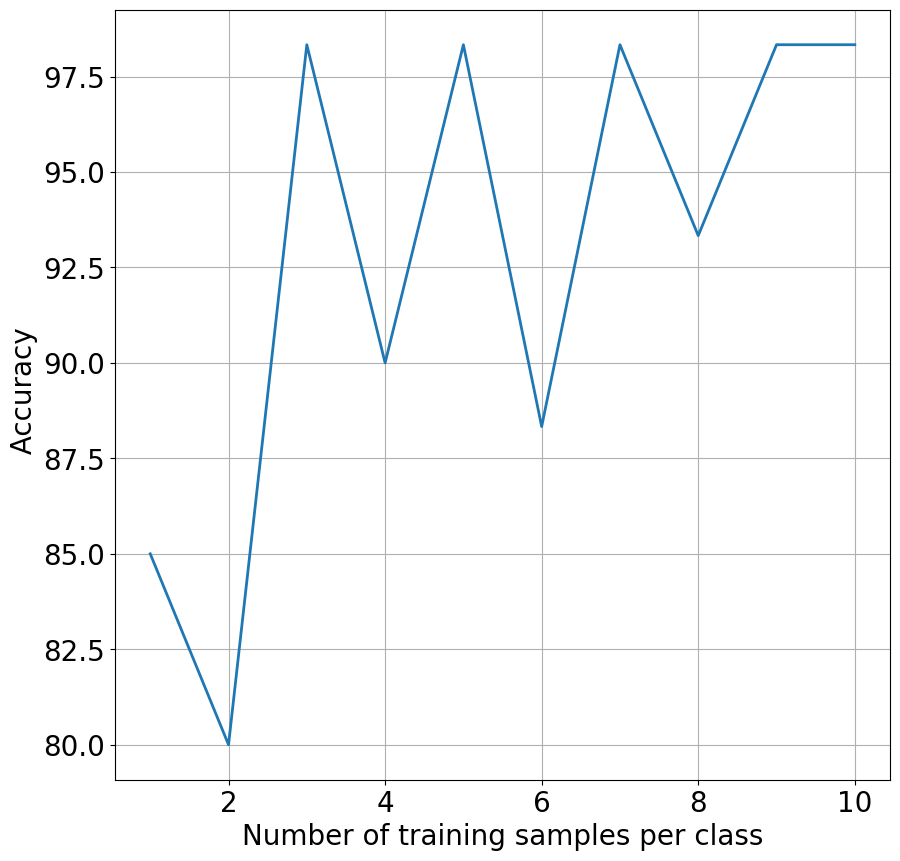

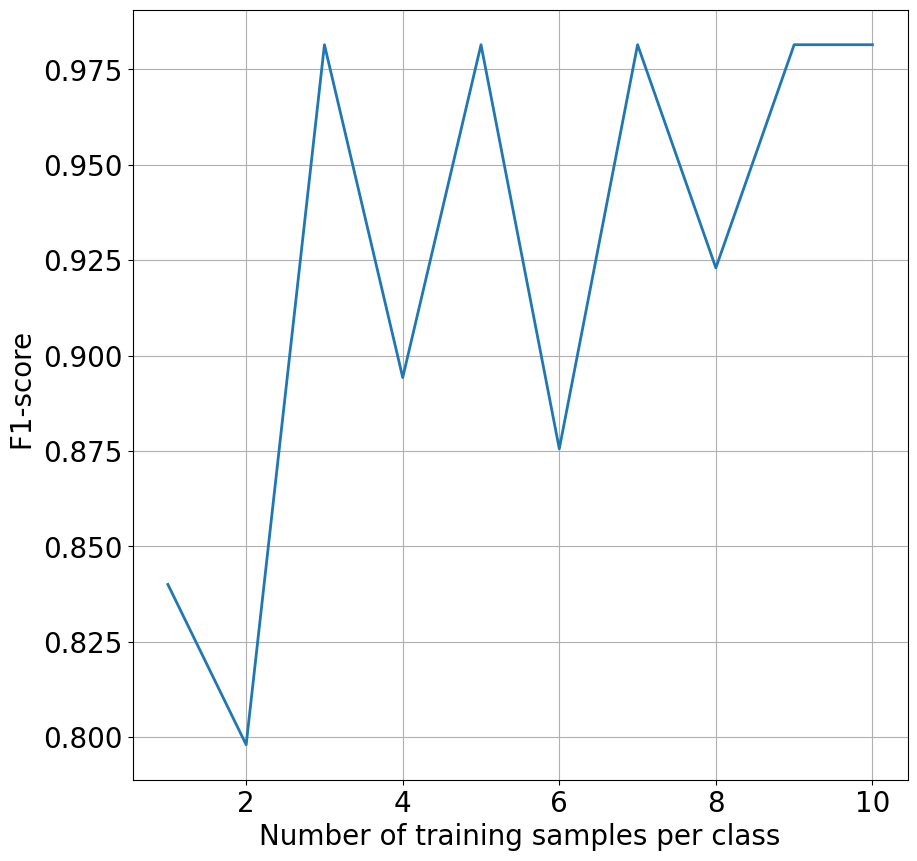

In [40]:

if __name__ == '__main__':
    data_name = "feivejiiiu.csv"
    var_num = 42
    X_train, y_train, X_test, y_test = get_data(data_name, var_num)
    a, b, c, q, length, num_classes, samples_per_class, check, details, var, method, epsilon = parameter_file(data_name)
    y_pred_val, avg_class_dist_1, ACC, PRECISION, RECALL, F1SCORE, avg_total_class_prob, test_proba = CHAOSNET(X_train, y_train, X_test, y_test, num_classes, samples_per_class, check, q, a, b, c, length, var, details, method, epsilon, data_name)

  